In [1]:
library("grf")
library(policytree)

Warning message:
"package 'grf' was built under R version 4.0.5"


In [3]:
#' Estimate a Rank-Weighted Average Treatment Effect (RATE).
#'
#' Consider a rule S(Xi) assigning scores to units in decreasing order of treatment prioritization.
#' In the case of a forest with binary treatment, we provide estimates of the following, where
#' 1/n <= q <= 1 represents the fraction of treated units:
#' \itemize{
#'   \item The Rank-Weighted Average Treatment Effect (RATE):
#'    \eqn{\int_{0}^{1} alpha(q) TOC(q; S) dq}, where alpha is a weighting method
#'    corresponding to either `AUTOC` or `QINI`.
#'   \item The Targeting Operating Characteristic (TOC):
#'     \eqn{E[Y(1) - Y(0) | F(S(Xi)) >= 1 - q] - E[Y(1) - Y(0)]}, where F(.) is the distribution function of S(Xi).
#' }
#' The Targeting Operating Characteristic (TOC) is a curve comparing the benefit of treating only a certain
#' fraction q of units (as prioritized by S(Xi)), to the overall average treatment effect.
#' The Rank-Weighted Average Treatment Effect (RATE) is a weighted sum of this curve,
#' and is a measure designed to identify prioritization rules that effectively targets treatment
#' (and can thus be used to test for the presence of heterogeneous treatment effects).
#'
#' @param forest The evaluation set forest.
#' @param priorities Treatment prioritization scores S(Xi) for the units used to train the evaluation forest.
#'  Two prioritization rules can be compared by supplying a two-column array or named list of priorities.
#'  WARNING: for valid statistical performance, these scores should be constructed independently from the evaluation
#'  forest training data.
#' @param target The type of RATE estimate, options are "AUTOC" (exhibits greater power when only a small subset
#'  of the population experience nontrivial heterogeneous treatment effects) or "QINI" (exhibits greater power
#'  when the entire population experience diffuse or substantial heterogeneous treatment effects).
#'  Default is "AUTOC".
#' @param q The grid q to compute the TOC curve on. Default is
#'  (10\%, 20\%, ..., 100\%).
#' @param R Number of bootstrap replicates for SEs. Default is 200.
#' @param subset Specifies subset of the training examples over which we
#'               estimate the RATE. WARNING: For valid statistical performance,
#'               the subset should be defined only using features Xi, not using
#'               the treatment Wi or the outcome Yi.
#' @param debiasing.weights A vector of length n (or the subset length) of debiasing weights.
#'               If NULL (default) these are obtained via the appropriate doubly robust score
#'               construction, e.g., in the case of causal_forests with a binary treatment, they
#'               are obtained via inverse-propensity weighting.
#' @param compliance.score Only used with instrumental forests. An estimate of the causal
#'               effect of Z on W, i.e., Delta(X) = E[W | X, Z = 1] - E[W | X, Z = 0],
#'               which can then be used to produce debiasing.weights. If not provided,
#'               this is estimated via an auxiliary causal forest.
#' @param num.trees.for.weights In some cases (e.g., with causal forests with a continuous
#'               treatment), we need to train auxiliary forests to learn debiasing weights.
#'               This is the number of trees used for this task. Note: this argument is only
#'               used when debiasing.weights = NULL.
#'
#' @references Yadlowsky, Steve, Scott Fleming, Nigam Shah, Emma Brunskill, and Stefan Wager.
#'  "Evaluating Treatment Prioritization Rules via Rank-Weighted Average Treatment Effects."
#'  arXiv preprint arXiv:2111.07966, 2021.
#'
#' @examples
#' \donttest{
#' # Train a causal forest to estimate a CATE based priority ranking
#' n <- 1500
#' p <- 5
#' X <- matrix(rnorm(n * p), n, p)
#' W <- rbinom(n, 1, 0.5)
#' event.prob <- 1 / (1 + exp(2*(pmax(2*X[, 1], 0) * W - X[, 2])))
#' Y <- rbinom(n, 1, event.prob)
#' train <- sample(1:n, n / 2)
#' cf.priority <- causal_forest(X[train, ], Y[train], W[train])
#'
#' # Compute a prioritization based on estimated treatment effects.
#' # -1: in this example the treatment should reduce the risk of an event occuring.
#' priority.cate <- -1 * predict(cf.priority, X[-train, ])$predictions
#'
#' # Estimate AUTOC on held out data.
#' cf.eval <- causal_forest(X[-train, ], Y[-train], W[-train])
#' rate <- rank_average_treatment_effect(cf.eval, priority.cate)
#' rate
#'
#' # Plot the Targeting Operator Characteristic curve.
#' plot(rate)
#'
#' # Compute a prioritization based on baseline risk.
#' rf.risk <- regression_forest(X[train[W[train] == 0], ], Y[train[W[train] == 0]])
#' priority.risk <- predict(rf.risk, X[-train, ])$predictions
#'
#' # Test if two RATEs are equal.
#' rate.diff <- rank_average_treatment_effect(cf.eval, cbind(priority.cate, priority.risk))
#' rate.diff
#'
#' # Construct a 95 % confidence interval.
#' # (a significant result suggests that there are HTEs and that the prioritization rule is effective
#' # at stratifying the sample based on them. Conversely, a non-significant result suggests that either
#' # there are no HTEs or the treatment prioritization rule does not predict them effectively.)
#' rate.diff$estimate + data.frame(lower = -1.96 * rate.diff$std.err,
#'                                 upper = 1.96 * rate.diff$std.err,
#'                                 row.names = rate.diff$target)
#' }
#'
#' @return A list of class `rank_average_treatment_effect` with elements \itemize{
#'  \item estimate: the RATE estimate.
#'  \item std.err: bootstrapped standard error of RATE.
#'  \item target: the type of estimate.
#'  \item TOC: a data.frame with the Targeting Operator Characteristic curve
#'    estimated on grid q, along with bootstrapped SEs.
#' }
#' @seealso \code{\link{rank_average_treatment_effect.fit}} for computing a RATE with user-supplied
#'  doubly robust scores.
#' @export
rank_average_treatment_effect.fit <- function(DR.scores,
                                              priorities,
                                              target = c("AUTOC", "QINI"),
                                              q = seq(0.1, 1, by = 0.1),
                                              R = 200,
                                              sample.weights = NULL,
                                              clusters = NULL) {
  target <- match.arg(target)
  if (anyNA(DR.scores)) {
    stop("`DR.scores` contains missing values.")
  }
  priorities <- as.data.frame(priorities, fix.empty.names = FALSE)
  if (ncol(priorities) > 2) {
    stop("`priorities` should be either a vector or a list/array with two rules.")
  }
  if (anyNA(priorities)) {
    stop("`priorities` contains missing values.")
  }
  if (nrow(priorities) != length(DR.scores)) {
    stop("`DR.scores` and `priorities` are not of same length.")
  }
  empty.names <- colnames(priorities) == ""
  colnames(priorities)[empty.names] <- c("priority1", "priority2")[1:ncol(priorities)][empty.names]
  priorities[,] <- lapply(priorities, function(x) as.integer(as.factor(x)))
  if (is.null(clusters)) {
    clusters <- 1:length(DR.scores)
  } else if (length(clusters) != length(DR.scores) || anyNA(clusters)) {
    stop("`clusters` has incorrect length.")
  } else {
    clusters <- as.numeric(as.factor(clusters)) - 1
  }
  if (is.null(sample.weights)) {
    sample.weights <- rep(1, length(DR.scores))
  } else if (length(sample.weights) != length(DR.scores) || anyNA(sample.weights)) {
    stop("`sample.weights` has incorrect length.")
  } else if (any(sample.weights <= 0)) {
    stop("`sample.weights` should be > 0.")
  } else {
    sample.weights <- sample.weights / sum(sample.weights)
  }
  if (is.unsorted(q, strictly = TRUE) || min(q) <= 0 || max(q) != 1) {
    stop("`q` should correspond to a grid of fractions on the interval (0, 1].")
  }

  # *** Compute the TOC and RATE ***

  if (target == "AUTOC") {
    wtd.mean <- function(x, w) sum(x * w) / sum(w)
  } else if (target == "QINI") {
    wtd.mean <- function(x, w) sum(cumsum(w) / sum(w) * w * x) / sum(w)
  }

  boot.output <- boot_grf(
    data = data.frame(DR.scores * sample.weights, sample.weights, priorities),
    # In case of two priorities do a paired bootstrap estimating both prios on same sample.
    statistic = function(data, indices, q, wtd.mean)
     lapply(c(4, 3)[1:ncol(priorities)], function(j) estimate_rate(data[, -j], indices, q, wtd.mean)),
    R = R,
    clusters = clusters,
    half.sample = TRUE,
    q = q,
    wtd.mean = wtd.mean
  )
  dim(boot.output[["t"]]) <- c(R, dim(boot.output[["t0"]]))
  point.estimate <- boot.output[["t0"]]
  std.errors <- apply(boot.output[["t"]], c(2, 3), sd)
  if (ncol(priorities) > 1) {
    point.estimate <- cbind(point.estimate, point.estimate[, 1] - point.estimate[, 2])
    std.errors <- cbind(std.errors, apply(boot.output[["t"]][,, 1] - boot.output[["t"]][,, 2], 2, sd))
  }
  point.estimate[abs(point.estimate) < 1e-15] <- 0
  std.errors[abs(std.errors) < 1e-15] <- 0
  if (R < 2) {
    std.errors[] <- 0
  }
  priority <- c(colnames(priorities), paste(colnames(priorities), collapse = " - "))[1:length(point.estimate[1, ])]

  output <- list()
  class(output) <- "rank_average_treatment_effect"
  output[["estimate"]] <- point.estimate[1, ]
  output[["std.err"]] <- std.errors[1, ]
  output[["target"]] <- paste(priority, "|", target)
  output[["TOC"]] <- data.frame(estimate = c(point.estimate[-1, ]),
                                std.err = c(std.errors[-1, ]),
                                q = q,
                                priority = priority[rep(1:length(priority), each = length(q))],
                                stringsAsFactors = FALSE)

  output
}

#' Compute rate estimates, a function to be passed on to bootstrap routine.
#' @param data A data.frame with the original data, column 1: DR.scores*sample.weights, column 2: sample.weights (positive),
#'  column 3: priority scores (integer vector with scores 1,...,num.unique.prios).
#' @param indices A vector of indices which define the bootstrap sample.
#' @param q A vector of fractions to compute TOC on, with last entry = 1.
#' @param wtd.mean A weighting function determining the type of RATE estimate.
#' @return an estimate of RATE, together with the TOC curve.
#'
#' @keywords internal
estimate_rate <- function(data, indices, q, wtd.mean) {
  # Let q be a fraction in (0, 1].
  # we have 1) TOC(q; Sj) = 1/[qn] sum_{i=1}^{[qn]} Gamma_{i(j)} - ATE
  # and 2) RATE = 1/n sum_{i=1}^{n} TOC(i/n; Sj)
  # For bootstrapping the TOC curve, we fix q on some grid q'.
  # For estimating the RATE we set 1/n <= q <= 1.
  # Observations:
  # a) the entire TOC curve can be computed as a cumulative sum of sorted DR.scores.
  # b) taking ties into account amounts to using the average DR.scores within each
  # tied group instead of the individual DR.scores.
  # So the steps are:
  # Compute average DR.scores by priority group in increasing order: DR.scores',
  # repeat the possibly tied entries with the number of duplicates.
  # Take the cumsum of this divided by ni to get the TOC curve. Take a (weighted) average
  # of this to get RATE. This is what is being done below, using base R's fastest primitives for
  # quick aggregation and grouping (using for example "rowsum"),
  # To accomodate sample weights and arbitrary q', we allow for fractional use of observations
  # when computing the TOC at user-specified grid points q'.
  prio <- data[indices, 3]
  sort.idx <- order(prio, decreasing = TRUE)
  sample.weights <- data[indices, 2][sort.idx]

  num.ties <- tabulate(prio) # count by rank in increasing order
  num.ties <- num.ties[num.ties > 0] # ignore potential ranks not present in BS sample
  # if continuous scoring then no need for ~slower aggregation
  if (all(num.ties == 1)) {
    DR.scores.sorted <- (data[indices, 1] / data[indices, 2])[sort.idx]
  } else {
    grp.sum <- rowsum(data[indices, 1:2][sort.idx, ], prio[sort.idx], reorder = FALSE)
    DR.avg <- grp.sum[, 1] / grp.sum[, 2]
    DR.scores.sorted <- rep.int(DR.avg, rev(num.ties))
  }
  sample.weights.cumsum <- cumsum(sample.weights)
  sample.weights.sum <- sample.weights.cumsum[length(sample.weights)]
  ATE <- sum(DR.scores.sorted * sample.weights) / sample.weights.sum
  TOC <- cumsum(DR.scores.sorted * sample.weights) / sample.weights.cumsum - ATE
  RATE <- wtd.mean(TOC, sample.weights)

  nw <- q * sample.weights.sum
  idx <- findInterval(nw + 1e-15, sample.weights.cumsum) # epsilon tol. since finite precision may cause not equal
  denominator.adj <- nw - sample.weights.cumsum[pmax(idx, 1)] # \sum weight remainder, zero when no fractional obs. needed
  numerator.adj <- denominator.adj * DR.scores.sorted[pmin(idx + 1, max(idx))]
  idx[idx == 0] <- 1
  uniq.idx <- unique(idx)
  grid.id <- rep.int(seq_along(uniq.idx), c(uniq.idx[1], diff(uniq.idx)))
  DR.scores.grid <- rowsum(cbind(DR.scores.sorted * sample.weights, sample.weights), grid.id, reorder = FALSE)
  TOC.grid <- (cumsum(DR.scores.grid[, 1])[grid.id[idx]] + numerator.adj) /
              (cumsum(DR.scores.grid[, 2])[grid.id[idx]] + denominator.adj) - ATE

  c(RATE, TOC.grid, use.names = FALSE)
}

#' Simple clustered bootstrap.
#'
#' Inspired by the `boot` function in the bootstrap package with clusters + half-sampling added.
#' A future TODO could be to add parallel (not necessarily worth it)
#' https://stat.ethz.ch/R-manual/R-devel/library/parallel/doc/parallel.pdf
#'
#' @param data A data frame with the original data.
#' @param statistic A function computing estimate(s) with signature (data, indices, ...) where
#' data is the original data, and indices a vector which defines the bootstrap sample.
#' @param R The number of bootstrap replications.
#' @param clusters Integer vector of cluster assignment, setting to 1:N corresponds to an ordinary
#'  unclustered bootstrap.
#' @param half.sample Whether to do half sample bootstrap (half the clusters are drawn). Default is TRUE.
#' @param ... Additional arguments passed on to statistic.
#' @return A list with the original estimate t0, and bootstrap estimates t.
#'
#' @references Angelo Canty and Brian Ripley (2021). boot: Bootstrap R (S-Plus) Functions.
#'
#' @keywords internal
boot_grf <- function(data, statistic, R, clusters, half.sample = TRUE, ...) {
  samples.by.cluster <- split(seq_along(clusters), clusters)
  n <- length(samples.by.cluster) # number of clusters
  if (n <= 1 || (half.sample && floor(n / 2) <= 1)) {
    stop("Cannot bootstrap sample with only one effective unit.")
  }
  if (half.sample) {
    n.bs <- floor(n / 2)
    index.list <- replicate(R, unlist(samples.by.cluster[sample.int(n, n.bs, replace = FALSE)], use.names = FALSE), simplify = FALSE)
  } else {
    index.list <- replicate(R, unlist(samples.by.cluster[sample.int(n, replace = TRUE)], use.names = FALSE), simplify = FALSE)
  }

  t0 <- statistic(data, seq_len(NROW(data)), ...)
  t0 <- matrix(unlist(t0), ncol = length(t0))

  res <- lapply(seq_len(R), function(i) statistic(data, index.list[[i]], ...))
  t <- matrix(, R, length(t0))
  for (r in seq_len(R)) {
    t[r, ] <- unlist(res[[r]])
  }

  list(t0 = t0, t = t)
}



In [2]:
CATE_train <- read.csv(file="C:\\Users\\user\\Desktop\\Thesis\\CATE_estimation_Y2.csv")
CATE_validation <- read.csv(file="C:\\Users\\user\\Desktop\\Thesis\\CATE_validation_Y2.csv")
validation_data <- read.csv(file="C:\\Users\\user\\Desktop\\Thesis\\health_test_Y2.csv")

In [3]:
StayOrNot <- as.matrix(as.integer(validation_data$LengthOfStay!=0))
CharlsonIndex <- as.matrix(validation_data$Y2_CharlsonIndex)
X<-as.matrix(subset(validation_data, select = -c(LengthOfStay, max_CharlsonIndex)))

In [4]:
cf.eval <- causal_forest(X,CharlsonIndex,StayOrNot)

In [5]:
StayOrNot_test <- as.matrix(as.integer(test_data$LengthOfStay!=0))
CharlsonIndex_test <- as.matrix(test_data$max_CharlsonIndex)
X_test<-as.matrix(subset(test_data, select = -c(LengthOfStay, max_CharlsonIndex)))

priority.cate <- -1 * predict(cf,X_test)$predictions

In [6]:
cf.eval <- causal_forest(X_test, CharlsonIndex_test, StayOrNot_test)

In [26]:
rate <- rank_average_treatment_effect.fit(CATE_validation$XLeaner, -1*CATE_train$DR,target = 'AUTOC')

In [13]:
rate <- rank_average_treatment_effect(cf.eval, -1*CATE_train$CausalForest)

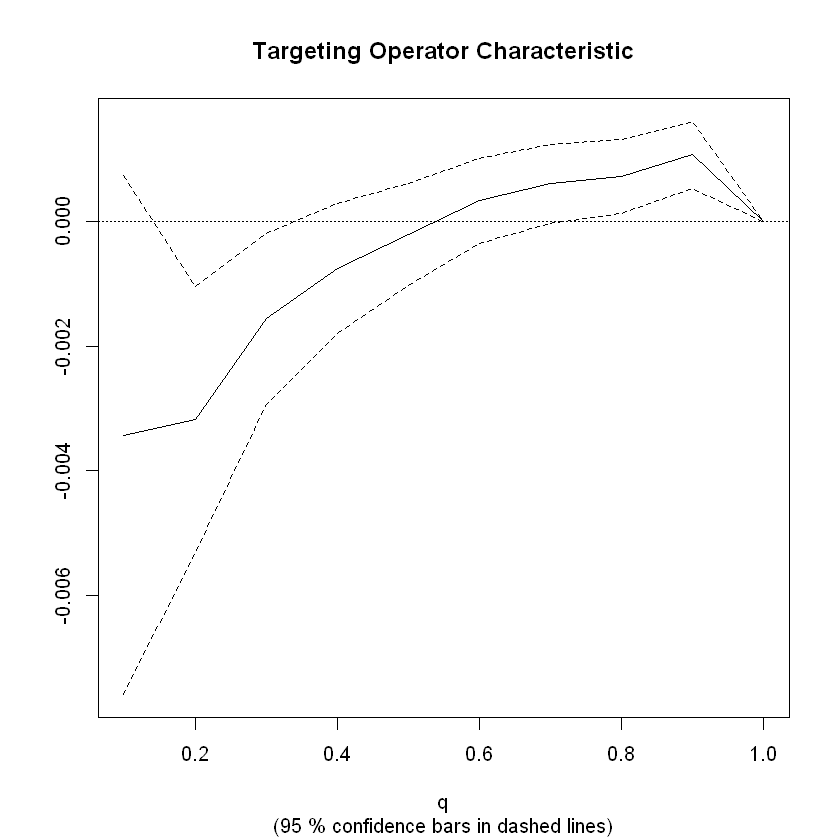

In [14]:
plot(rate)


In [15]:
rate$estimate

[1] -0.0007474061